# Decoherence Channels

Sanity checks to verify that everything is working

consider single triplet qubit

\begin{equation}
H = \frac{J + \delta J}{2}\sigma_z + E_z \sigma_x
\end{equation}

where $\delta J$ is white noise.

## $T_1$ Decay

We start by considering a pure depolarizing decay.

In [2]:
from qopt import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize


def create_lindblad_solver(n_time_steps, noise_variance,
                           total_time, bz_rotation):
    delta_bz = bz_rotation / total_time
    delta_t = total_time / n_time_steps

    def prefactor_function(transferred_parameters, _):
        return noise_variance * np.ones_like(transferred_parameters)

    lindblad_solver = LindbladSolver(
        h_drift=[delta_bz * .5 * DenseOperator.pauli_x()],
        h_ctrl=[.5 * DenseOperator.pauli_z()],
        tau=delta_t * np.ones(n_time_steps),
        prefactor_function=prefactor_function,
        lindblad_operators=[.5 * DenseOperator.pauli_z()]
    )
    return lindblad_solver

def evaluate_infidelity_fid_lindblad(n_time_steps, noise_variance,
                                     total_time, bz_rotation):
    lindblad_solver = create_lindblad_solver(
        n_time_steps, noise_variance, total_time, bz_rotation)

    fid_ctrl_amps = np.expand_dims(np.zeros(n_time_steps), 1)
    target = (.5 * DenseOperator.pauli_x()).exp(1j * bz_rotation)
    lindblad_cost_fkt = OperationInfidelity(
        solver=lindblad_solver,
        super_operator_formalism=True,
        target=target
    )
    lindblad_solver.set_optimization_parameters(fid_ctrl_amps)

    return lindblad_cost_fkt.costs()

def create_mc_solver(n_time_steps, noise_variance, total_time, bz_rotation,
                     low_freq_ex):
    delta_bz = bz_rotation / total_time
    delta_t = total_time / n_time_steps


    def noise_spectral_density(f):
        return 2 * noise_variance * np.ones_like(f)  # factor of 2 for
        # one-sided spectrum

    noise_trace_generator = NTGColoredNoise(
        n_samples_per_trace=n_time_steps,
        dt=delta_t,
        noise_spectral_density=noise_spectral_density,
        n_traces=1000,
        low_frequency_extension_ratio=low_freq_ex
    )

    monte_carlo_solver = SchroedingerSMonteCarlo(
        h_drift=[delta_bz * .5 * DenseOperator.pauli_x()],
        h_ctrl=[.5 * DenseOperator.pauli_z()],
        tau=delta_t * np.ones(n_time_steps),
        h_noise=[.5 * DenseOperator.pauli_z()],
        noise_trace_generator=noise_trace_generator
    )

    return monte_carlo_solver


def evaluate_fidelity_fid_mc(
        n_time_steps, noise_variance, total_time, bz_rotation, low_freq_rel):
    monte_carlo_solver = create_mc_solver(
        n_time_steps, noise_variance, total_time, bz_rotation, low_freq_rel)
    fid_ctrl_amps = np.expand_dims(np.zeros(n_time_steps), 1)
    target = (.5 * DenseOperator.pauli_x()).exp(1j * bz_rotation)

    mc_cost_fkt = OperationNoiseInfidelity(
        solver=monte_carlo_solver,
        target=target,
        neglect_systematic_errors=False
    )

    monte_carlo_solver.set_optimization_parameters(fid_ctrl_amps)
    return mc_cost_fkt.costs()

def t2_decay(t, t2):
    return np.exp(-1. * t / t2)

In [50]:
n_values = 20
total_time = 1
n_time_step_values = np.logspace(
    2, 4, n_values, dtype=int, endpoint=True, base=10)
lindblad_fidelity_nt = evaluate_infidelity_fid_lindblad(n_time_steps=10,
                                                        noise_variance=.01,
                                                        total_time=total_time,
                                                        bz_rotation=np.pi)
mc_fidelities_nt = np.zeros(n_values)

for i, n_time_step in enumerate(n_time_step_values):
    mc_fidelity = evaluate_fidelity_fid_mc(
        n_time_steps=n_time_step, noise_variance=.01, total_time=total_time,
        bz_rotation=np.pi
    )
    mc_fidelities_nt[i] = mc_fidelity

KeyboardInterrupt: 

In [ ]:
plt.plot(n_time_step_values, mc_fidelities_nt)
plt.hlines(lindblad_fidelity_nt, xmin=n_time_step_values[0],
           xmax=n_time_step_values[-1])
plt.xscale('log')

In [3]:
total_time = 2
n_variance_values = 15
noise_variance_values = np.logspace(
    -4, -1, n_variance_values, dtype=float, endpoint=True, base=10)
mc_fidelities_variance = np.zeros(n_variance_values)
lindblad_fidelities_variance = np.zeros(n_variance_values)

for i, noise_variance in enumerate(noise_variance_values):
    lindblad_fidelity = evaluate_infidelity_fid_lindblad(
        n_time_steps=10, noise_variance=noise_variance, total_time=total_time,
        bz_rotation=np.pi
    )
    lindblad_fidelities_variance[i] = lindblad_fidelity
    mc_fidelity = evaluate_fidelity_fid_mc(
        n_time_steps=300, noise_variance=noise_variance, total_time=total_time,
        bz_rotation=np.pi, low_freq_rel=10)
    mc_fidelities_variance[i] = mc_fidelity

C:\Users\julia\.conda\envs\texplots\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """Entry point for launching an IPython kernel.


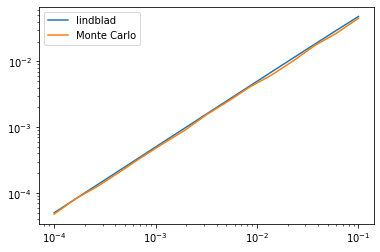

In [4]:
plt.plot(noise_variance_values, lindblad_fidelities_variance, Label='lindblad')
plt.plot(noise_variance_values, mc_fidelities_variance, label='Monte Carlo')
plt.xscale('log')
plt.yscale('log')
plt.legend()

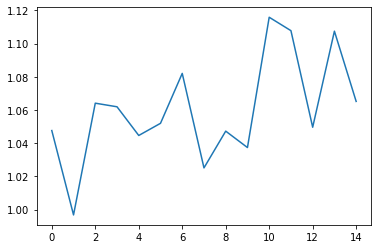

In [5]:
plt.plot(lindblad_fidelities_variance / mc_fidelities_variance)

In [6]:
np.mean(lindblad_fidelities_variance / mc_fidelities_variance)

1.0603186713306636

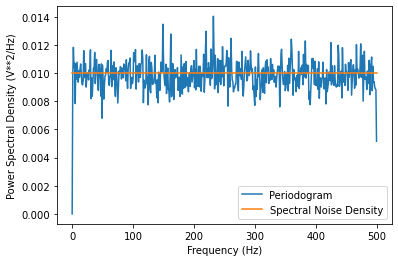

0.021852728137663507

In [21]:
mc_solver = create_mc_solver(n_time_steps=1000, noise_variance=.01)
mc_solver.noise_trace_generator.plot_periodogram(100)

In [44]:
n_total_time_values = 10
total_time_values = np.logspace(-2, 1, n_total_time_values)

mc_fidelities_t_total = np.zeros(n_total_time_values)
lindblad_fidelities_t_total = np.zeros(n_total_time_values)

for i, total_t in enumerate(total_time_values):
    lindblad_fidelity = evaluate_infidelity_fid_lindblad(
        n_time_steps=10, noise_variance=.01, total_time=total_t,
        bz_rotation=np.pi)
    lindblad_fidelities_t_total[i] = lindblad_fidelity
    mc_fidelity = evaluate_fidelity_fid_mc(
        n_time_steps=300, noise_variance=.01, total_time=total_t,
        bz_rotation=np.pi)
    mc_fidelities_t_total[i] = mc_fidelity

C:\Users\julia\.conda\envs\texplots\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """Entry point for launching an IPython kernel.


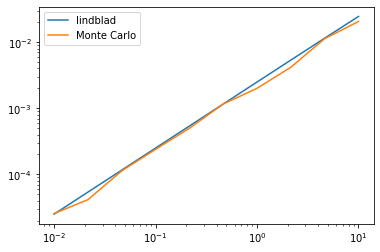

In [45]:
plt.plot(total_time_values, lindblad_fidelities_t_total, Label='lindblad')
plt.plot(total_time_values, mc_fidelities_t_total, label='Monte Carlo')
plt.legend()
plt.xscale('log')
plt.yscale('log')

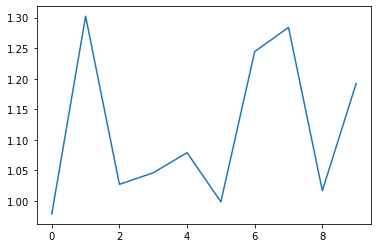

In [46]:
plt.plot(lindblad_fidelities_t_total / mc_fidelities_t_total)

In [48]:
np.mean(lindblad_fidelities_t_total / mc_fidelities_t_total / np.pi)

0.3555389936661788

lets calculate the T1 time

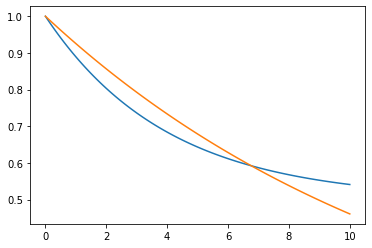

In [19]:
import scipy.optimize

total_time = 10
lindblad_solver = create_lindblad_solver(
    n_time_steps=100, noise_variance=.5, total_time=total_time, bz_rotation=0)
fid_ctrl_amps = np.expand_dims(np.zeros(100), 1)
lindblad_solver.set_optimization_parameters(fid_ctrl_amps)

propagators = lindblad_solver.forward_propagators

In [33]:
def vectorize(rho):
    d_square = int(rho.shape[0] ** 2)
    return DenseOperator(np.reshape(rho.data.T, (d_square, 1)))

def devectorize(rho_vec):
    d = int(np.round(np.sqrt(rho_vec.shape[0])))
    return DenseOperator(np.reshape(rho_vec.data, (d, d)).T)

def measure_x(rho):
    return (rho * DenseOperator.pauli_x()).tr()

C:\Users\julia\.conda\envs\texplots\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\julia\.conda\envs\texplots\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


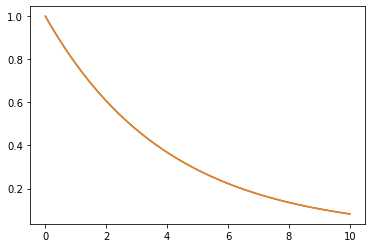

In [42]:
plus = DenseOperator((1 / np.sqrt(2)) * np.asarray([[1], [1]]))
rho_0 = plus * plus.dag()

x_projections = [
    measure_x(devectorize(p * vectorize(rho_0))) for p in propagators
]

def t2_decay(t, t2):
    return np.exp(-1. * t / t2)

popt, pcov = scipy.optimize.curve_fit(
    t2_decay,
    xdata= total_time / 100 * np.arange(101),
    ydata=x_projections,
    p0=np.asarray([1 / .5])
)

plt.plot(total_time / 100 * np.arange(101), x_projections)
plt.plot(total_time / 100 * np.arange(101),
         t2_decay(total_time / 100 * np.arange(101), popt[0]))

In [41]:
popt

array([4.])

In [41]:
infids = [entanglement_fidelity_super_operator(
    target=DenseOperator(np.eye(2)),propagator=p)
    for p in propagators
 ]

def t1_decay(t, t1):
    return np.exp(-1 * (t / t1))
popt, pcov = scipy.optimize.curve_fit(
    t1_decay,
    xdata= total_time / 100 * np.arange(101),
    ydata=infids,
    p0=np.asarray([1 / .5])
)
plt.plot(total_time / 100 * np.arange(101), infids)
plt.plot(total_time / 100 * np.arange(101),
         t1_decay(total_time / 100 * np.arange(101), popt[0]))

In [12]:
total_time = 1
n_time_steps = 200
mc_solver = create_mc_solver(
    n_time_steps=n_time_steps, noise_variance=.8, total_time=total_time,
    bz_rotation=0, low_freq_ex=100)
fid_ctrl_amps = np.expand_dims(np.zeros(n_time_steps), 1)
mc_solver.set_optimization_parameters(fid_ctrl_amps)

propagators_mc = mc_solver.forward_propagators_noise

In [13]:
plus = DenseOperator((1 / np.sqrt(2)) * np.asarray([[1], [1]]))

x_projections = np.zeros(n_time_steps + 1, dtype=complex)


for propagators in propagators_mc:

    propagated_states_mc = [
        u * plus for u in propagators
    ]
    x_projections_mc = [
        (vec.dag() * DenseOperator.pauli_x() * vec)[0, 0]
        for vec in propagated_states_mc
    ]
    x_projections += np.asarray(x_projections_mc)

x_projections /= mc_solver.noise_trace_generator.n_traces

5.105916812687589


C:\Users\julia\.conda\envs\texplots\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\julia\.conda\envs\texplots\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


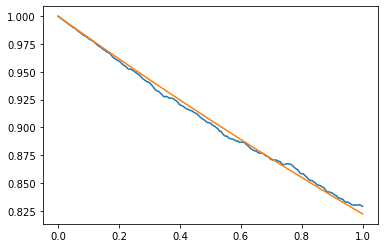

In [14]:
import scipy.optimize
def t2_decay(t, t2):
    return np.exp(-1. * t / t2)
popt, pcov = scipy.optimize.curve_fit(
    t2_decay,
    xdata= total_time / n_time_steps * np.arange(n_time_steps + 1),
    ydata=x_projections,
    p0=np.asarray([1 / .5])
)

plt.plot(total_time / n_time_steps * np.arange(n_time_steps + 1), x_projections)
plt.plot(total_time / n_time_steps * np.arange(n_time_steps + 1),
         t2_decay(total_time / n_time_steps * np.arange(n_time_steps + 1),
                  popt[0]))
print(popt[0])

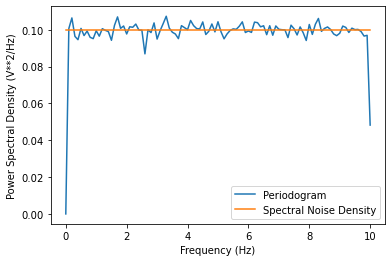

0.031144564476372844

In [9]:
mc_solver.noise_trace_generator.plot_periodogram(1000)

In [17]:
n_values = 10
total_time = 1
# low_freq_rel_values = np.logspace(
#    0, 1, n_values, dtype=int, endpoint=True, base=10)
low_freq_rel_values = np.arange(10, dtype=int) + 1
lindblad_fidelity_nt = evaluate_infidelity_fid_lindblad(n_time_steps=10,
                                                        noise_variance=.01,
                                                        total_time=total_time,
                                                        bz_rotation=np.pi)
mc_fidelities_nt = np.zeros(n_values)

for i, low_freq_rel in enumerate(low_freq_rel_values):
    mc_fidelity = evaluate_fidelity_fid_mc(
        n_time_steps=200, noise_variance=.01, total_time=total_time,
        bz_rotation=np.pi, low_freq_rel=low_freq_rel
    )
    mc_fidelities_nt[i] = mc_fidelity

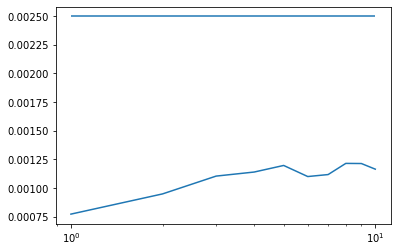

In [18]:
plt.plot(low_freq_rel_values, mc_fidelities_nt)
plt.hlines(lindblad_fidelity_nt, xmin=low_freq_rel_values[0],
           xmax=low_freq_rel_values[-1])
plt.xscale('log')

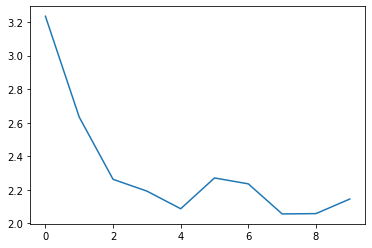

In [19]:
plt.plot(lindblad_fidelity_nt / mc_fidelities_nt)